In [2]:
import pandas as pd
import os
import pickle
os.chdir('..')
import plotly.express as px
from utils import *

# ml imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import DMatrix
import xgboost as xgb

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# logging
from matplotlib import pyplot as plt
import wandb
from wandb.xgboost import WandbCallback
from bayes_opt import BayesianOptimization

wandb.login()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(
    project="XGBoost_rolling",
    )

In [4]:
config_features = {
    'h_ahead': 24, # in hours,
    'timesteplen': 15, # in minutes
    'holidays': True,
    'holidays_country': 'AT',
    'peaks': True,
    'lagged_days': [1,7,14],
    'boxcox': True,
    'lam': None,
    'cumsum': True,
    'datetime': True,
    }


In [5]:
df_first = pd.read_csv(r'data\raw_data\UTC_id1_data.csv', sep=';')
df_first.index = pd.to_datetime(df_first['timestamp'], format='%d.%m.%Y %H:%M')
df_first = df_first.iloc[:,[1]]
df_first = df_first.resample(f"{config_features['timesteplen']}min").mean()
df_first.columns = ['power']

In [6]:
# Data cleaning
#-----------------------#
df = remove_duplicate_index(df_first)

df = remove_days(df)

df = remove_non_positive_values(df)

df_clean = df.copy()

In [7]:
fig = px.line(df_clean)
wandb.log({'clean_data': fig})

Text(0, 0.5, 'Frequency')

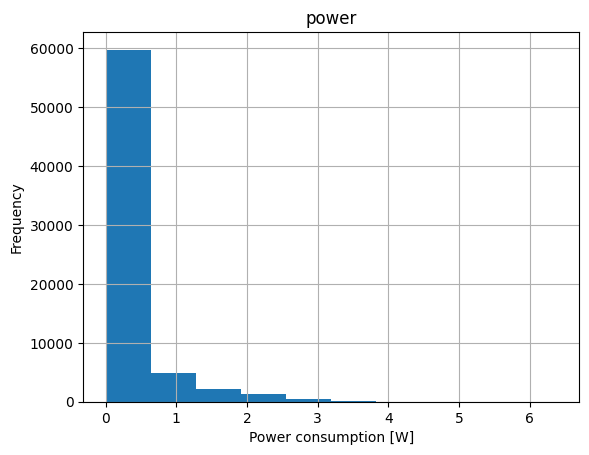

In [8]:
fig = df_clean.hist()
plt.xlabel('Power consumption [W]')
plt.ylabel('Frequency')
#wandb.log({'hist': wandb.Image(fig)})

In [9]:
def get_df_outputs(df, n_ahead=24):
    df_outputs = df.copy()

    for i in range(n_ahead):
        df_outputs[f'timestep_{i}'] = df_outputs['power'].shift(-i)

    df_outputs = df_outputs.dropna()
    df_outputs = df_outputs.iloc[:,-n_ahead:]

    return df_outputs

def create_datetime_features_rolling(df):
    
    timesteplen = infer_frequency(df).seconds // 60
    df['timestep_of_day'] = (df.index.hour * 60 + df.index.minute) // timesteplen 
    df['day_of_week'] = df.index.dayofweek
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df.drop('day_of_week', axis=1, inplace=True)
    df['month'] = df.index.month
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    # is weekend
    df['is_weekend'] = df.index.dayofweek > 4
    df.drop('month', axis=1, inplace=True)
    return df



def encode_peaks(df_output):
    """
    
    
    """


    df = df_output.iloc[:,[0]]
    timesteplen = infer_frequency(df).seconds // 60
    timesteps_per_day = 24*60//timesteplen

    # Find peaks
    peak_idx = find_peaks_cwt(df.values.flatten(), widths=3, max_distances=[timesteps_per_day//2], window_size=timesteps_per_day)

    # Convert peak indices to datetime indices
    peak_times = [df.index[i] for i in peak_idx]

    df_peak_times = pd.DataFrame({'is_peak':1}, index = peak_times)
    df_concat = pd.concat([df, df_peak_times], axis=1)
    df_concat['timestemps_since_last_peak'] = 0
    df_concat['peak_height'] = 0
    timesteplen = infer_frequency(df).seconds // 60 # in minutes

    for ind in df_concat.index:
        most_recent_peak = df_concat["is_peak"].loc[:ind].last_valid_index()
        if most_recent_peak is None:
            df_concat.loc[ind, "timestemps_since_last_peak"] = np.nan
            continue
        peak_height = df_concat.iloc[:,0].loc[most_recent_peak]
        minutes_since_last_peak = (ind - most_recent_peak).seconds // 60
        if minutes_since_last_peak == 0:
            df_concat.loc[ind, "timestemps_since_last_peak"] = 0
            df_concat.loc[ind, "peak_height"] = peak_height
            continue
        timesteps_since_last_peak = minutes_since_last_peak // timesteplen
        df_concat.loc[ind, "timestemps_since_last_peak"] = timesteps_since_last_peak
        df_concat.loc[ind, "peak_height"] = peak_height
    df_concat = df_concat.iloc[:,2:]

    return df_concat



In [10]:
wandb.config.update(config_features)

config = wandb.config


In [11]:

df = df_clean.copy()
# Feature Engineering
#-----------------------#
if config.boxcox:
    df, config.lam = boxcox_transform(df)



In [12]:
config.lam

0.16940937371840703

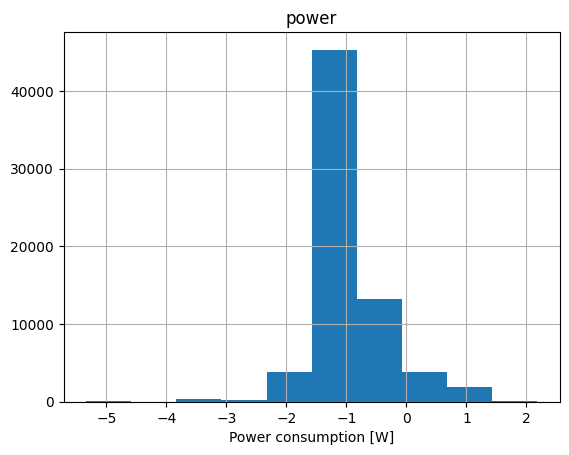

In [13]:
df.hist()
fig =plt.xlabel('Power consumption [W]')
#wandb.log({'histogram_after_box-cox_transform': fig})

In [14]:
# scaling the data

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

df_outputs = get_df_outputs(df, n_ahead=config.h_ahead)

if config.peaks:
    df_peaks = encode_peaks(df_outputs)
    df_outputs = pd.concat([df_outputs, df_peaks], axis=1)


df_outputs

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,...,timestep_16,timestep_17,timestep_18,timestep_19,timestep_20,timestep_21,timestep_22,timestep_23,timestemps_since_last_peak,peak_height
2021-04-01 00:00:00,0.528625,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,...,0.521812,0.513762,0.549026,0.555659,0.526056,0.561595,0.667547,0.645890,NaN,0.000000
2021-04-01 00:15:00,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,...,0.513762,0.549026,0.555659,0.526056,0.561595,0.667547,0.645890,0.549980,NaN,0.000000
2021-04-01 00:30:00,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,...,0.549026,0.555659,0.526056,0.561595,0.667547,0.645890,0.549980,0.509507,NaN,0.000000
2021-04-01 00:45:00,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,...,0.555659,0.526056,0.561595,0.667547,0.645890,0.549980,0.509507,0.580412,0.0,0.548999
2021-04-01 01:00:00,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,...,0.526056,0.561595,0.667547,0.645890,0.549980,0.509507,0.580412,0.598211,1.0,0.548999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 17:00:00,0.635642,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,...,0.546765,0.552665,0.555425,0.536598,0.570577,0.568147,0.525727,0.523969,25.0,0.757052
2023-04-24 17:15:00,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,...,0.552665,0.555425,0.536598,0.570577,0.568147,0.525727,0.523969,0.539638,26.0,0.757052
2023-04-24 17:30:00,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,...,0.555425,0.536598,0.570577,0.568147,0.525727,0.523969,0.539638,0.573190,0.0,0.617654
2023-04-24 17:45:00,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,0.556667,...,0.536598,0.570577,0.568147,0.525727,0.523969,0.539638,0.573190,0.580841,1.0,0.617654


In [15]:
# past information
if config.cumsum:
    for i in config.lagged_days:
        df_outputs[f"summed_load_of_day_{i}"] = df_outputs.sum(axis=1).shift(1)



In [16]:
df_outputs

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,...,timestep_19,timestep_20,timestep_21,timestep_22,timestep_23,timestemps_since_last_peak,peak_height,summed_load_of_day_1,summed_load_of_day_7,summed_load_of_day_14
2021-04-01 00:00:00,0.528625,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,...,0.555659,0.526056,0.561595,0.667547,0.645890,NaN,0.000000,NaN,NaN,NaN
2021-04-01 00:15:00,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,...,0.526056,0.561595,0.667547,0.645890,0.549980,NaN,0.000000,13.030305,13.030305,13.030305
2021-04-01 00:30:00,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,...,0.561595,0.667547,0.645890,0.549980,0.509507,NaN,0.000000,13.051660,26.081964,39.112269
2021-04-01 00:45:00,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,...,0.667547,0.645890,0.549980,0.509507,0.580412,0.0,0.548999,13.060168,26.111828,52.193792
2021-04-01 01:00:00,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,...,0.645890,0.549980,0.509507,0.580412,0.598211,1.0,0.548999,13.668108,26.728276,52.840104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 17:00:00,0.635642,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,...,0.536598,0.570577,0.568147,0.525727,0.523969,25.0,0.757052,39.189265,77.432395,152.951371
2023-04-24 17:15:00,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,...,0.570577,0.568147,0.525727,0.523969,0.539638,26.0,0.757052,40.143284,79.332549,156.764945
2023-04-24 17:30:00,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,...,0.568147,0.525727,0.523969,0.539638,0.573190,0.0,0.617654,41.047280,81.190565,160.523114
2023-04-24 17:45:00,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,0.556667,...,0.525727,0.523969,0.539638,0.573190,0.580841,1.0,0.617654,14.921376,55.968656,137.159221


In [17]:
# holidays
if config.holidays:
    years = get_year_list(df_outputs)
    df_holidays_dummies = get_holidays(years, config.holidays_country)
    df_holidays = create_holiday_features(df_outputs, df_holidays_dummies)
    df_outputs = pd.concat([df_outputs, df_holidays], axis=1)

    


In [18]:
df_outputs

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,...,timestep_21,timestep_22,timestep_23,timestemps_since_last_peak,peak_height,summed_load_of_day_1,summed_load_of_day_7,summed_load_of_day_14,days_until_next_holiday,days_since_last_holiday
2021-04-01 00:00:00,0.528625,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,...,0.561595,0.667547,0.645890,NaN,0.000000,NaN,NaN,NaN,4,85
2021-04-01 00:15:00,0.500998,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,...,0.667547,0.645890,0.549980,NaN,0.000000,13.030305,13.030305,13.030305,3,85
2021-04-01 00:30:00,0.521471,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,...,0.645890,0.549980,0.509507,NaN,0.000000,13.051660,26.081964,39.112269,3,85
2021-04-01 00:45:00,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,...,0.549980,0.509507,0.580412,0.0,0.548999,13.060168,26.111828,52.193792,3,85
2021-04-01 01:00:00,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,...,0.509507,0.580412,0.598211,1.0,0.548999,13.668108,26.728276,52.840104,3,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 17:00:00,0.635642,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,...,0.568147,0.525727,0.523969,25.0,0.757052,39.189265,77.432395,152.951371,6,14
2023-04-24 17:15:00,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,...,0.525727,0.523969,0.539638,26.0,0.757052,40.143284,79.332549,156.764945,6,14
2023-04-24 17:30:00,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,...,0.523969,0.539638,0.573190,0.0,0.617654,41.047280,81.190565,160.523114,6,14
2023-04-24 17:45:00,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,0.556667,...,0.539638,0.573190,0.580841,1.0,0.617654,14.921376,55.968656,137.159221,6,14


In [19]:

# datetime features
if config.datetime:
    df_outputs = create_datetime_features_rolling(df_outputs)


In [20]:

df_final = df_outputs.astype('float32').iloc[1:-1,:].dropna()

#-----------------------#



In [21]:
df_final

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,...,summed_load_of_day_7,summed_load_of_day_14,days_until_next_holiday,days_since_last_holiday,timestep_of_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,is_weekend
2021-04-01 00:45:00,0.548999,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,...,26.111828,52.193790,3.0,85.0,3.0,0.433884,-0.900969,0.866025,-0.5,0.0
2021-04-01 01:00:00,0.564972,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,...,26.728277,52.840103,3.0,85.0,4.0,0.433884,-0.900969,0.866025,-0.5,0.0
2021-04-01 01:15:00,0.489616,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,0.503956,...,28.385427,55.113705,3.0,85.0,5.0,0.433884,-0.900969,0.866025,-0.5,0.0
2021-04-01 01:30:00,0.370233,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,0.503956,0.554039,...,30.504702,58.890129,3.0,85.0,6.0,0.433884,-0.900969,0.866025,-0.5,0.0
2021-04-01 01:45:00,0.575730,0.568864,0.570623,0.534560,0.579527,0.546458,0.530286,0.503956,0.554039,0.521812,...,32.615082,63.119785,3.0,85.0,7.0,0.433884,-0.900969,0.866025,-0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 16:45:00,0.569950,0.635642,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,...,75.518974,149.143951,6.0,14.0,67.0,0.000000,1.000000,0.866025,-0.5,0.0
2023-04-24 17:00:00,0.635642,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,...,77.432396,152.951370,6.0,14.0,68.0,0.000000,1.000000,0.866025,-0.5,0.0
2023-04-24 17:15:00,0.559696,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,...,79.332550,156.764938,6.0,14.0,69.0,0.000000,1.000000,0.866025,-0.5,0.0
2023-04-24 17:30:00,0.617654,0.621998,0.607383,0.594213,0.615223,0.637239,0.680340,0.628588,0.635193,0.606533,...,81.190567,160.523117,6.0,14.0,70.0,0.000000,1.000000,0.866025,-0.5,0.0


In [22]:


# Splits 

#-----------------------#
test_size = 0.1
train, test = train_test_split(df_final, test_size=test_size, shuffle=False, random_state=42)
test_idx = test.index


In [23]:

#features and target
X_train = train.iloc[:,config_features['h_ahead']:]
y_train = train.iloc[:,:config_features['h_ahead']]

X_test = test.iloc[:,config_features['h_ahead']:]
y_test = test.iloc[:,:config_features['h_ahead']]


scaler_features = MinMaxScaler()
X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

#-----------------------#


dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)


In [24]:
params = {'colsample_bytree': 0.9, 
            'learning_rate': 0.2, 
            'max_depth': 15, 
            'min_child_weight': 1,
            'reg_lambda': 0.4,
            'subsample': 0.6,
            'gamma': 0,
            'objective': 'reg:pseudohubererror',
            'huber_slope': 0.15,
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'num_parallel_tree': 1,
             }

        
wandb.config.update(params)
model = xgb.train(dtrain= dtrain, params=params, 
                  early_stopping_rounds=15,
                  evals=[(dtest, "Test"), (dtrain, "Train")], 
                  custom_metric=peak_error, maximize=False, verbose_eval=10, callbacks=[WandbCallback()])

predictions = model.predict(dtest)


[0]	Test-mphe:0.00258	Test-peak_error:0.11272	Train-mphe:0.00424	Train-peak_error:0.15552
[9]	Test-mphe:0.00170	Test-peak_error:0.06603	Train-mphe:0.00109	Train-peak_error:0.07395


In [25]:
def post_process_xgb_predictions(predictions, boxcox_bool, scaler=None, lam = None):
    'Post-process the predictions of the Multi-Output XGBoost model'
    predictions_reshaped = predictions[::config_features['h_ahead'], :].reshape(-1,)[:-1]
    # set negative predictions to 5th percentile of the training data
    predictions_reshaped[predictions_reshaped < 0] = np.quantile(predictions_reshaped, 0.05)   
    # reverse the scaling and boxcox transformation of the predictions
    if scaler is not None:
        predictions_reshaped = scaler.inverse_transform(predictions_reshaped.reshape(-1,1)).flatten()
    if boxcox_bool:
        predictions_reshaped = inverse_boxcox_transform(pd.DataFrame(predictions_reshaped), lam).values.flatten()
    return predictions_reshaped


predictions = post_process_xgb_predictions(predictions, config.boxcox, scaler=scaler, lam=config.lam)

In [26]:
gt = df_first.loc[test_idx].values.flatten()

df_compare = pd.DataFrame({
                        'ground truth':gt,
                        'prediction': predictions
                        }
                        )


# -----------------------#
fig2 = px.line(df_compare)
fig2.update_layout(title='XGBoost Predictions vs Ground Truth: Michael Stadler Household Data')
fig2.show()
wandb.log({"Line-Plot":fig2})



In [27]:
def xgb_obj(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators , reg_lambda, reg_alpha, huber_slope, gamma):
    
    wandb.init(project='XGBoost_rolling')
    wandb.config.update(config_features)
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': int(n_estimators),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'huber_slope': huber_slope,
        'gamma': gamma, 
        # defaults
        'objective': 'reg:pseudohubererror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    wandb.config.update(params)

    model = xgb.train(params, dtrain, evals=[(dtest, "Test"), (dtrain, "Train")],
                      early_stopping_rounds=15, feval=peak_error, maximize=False, verbose_eval=10, callbacks = [WandbCallback()])
    predictions = model.predict(dtest)

    predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, config.lam)
    gt = df_first.loc[test_idx].values.flatten()

    df_compare = pd.DataFrame({
                            'gt':gt,
                            'per_timestep': predictions_reshaped
                            }
                            )
    

    fig = px.line(df_compare)
    wandb.log({"Side-by-Side": fig})
    # -----------------------

    
    error = peak_error(predictions, dtest)[1]
    dtw_distance = dtw_error(predictions, dtest)[1]
    wandb.log({"dtw_distance": dtw_distance})

    
    return -error  # Negative since BayesOpt minimizes the objective function


In [28]:
params = {'colsample_bytree': 0.9, 
            'learning_rate': 0.2, 
            'max_depth': 15, 
            'min_child_weight': 1,
            'reg_lambda': 0.4,
            'subsample': 0.6,
            'gamma': 0,
            'objective': 'reg:pseudohubererror',
            'huber_slope': 0.15,
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'num_parallel_tree': 1,
             }

# Define bounds for hyperparameters
pbounds = {
    'learning_rate': (0.05, 0.3),
    'max_depth': (7, 20),
    'min_child_weight': (1, 5),
    'subsample': (0.7, 1),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (0.1, 0.6),
    'reg_alpha': (0.1, 0.2),
    'n_estimators': (500, 2500),
    'huber_slope': (0.05, 0.5),
    'gamma': (0, 0.3),
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_obj, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=20, n_iter=100)

# Print optimal hyperparameters and their corresponding error
print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | huber_... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06603
Train-peak_error,0.07395
best_iteration,9
best_score,0.07395


[17:18:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00326	Test-peak_error:0.15828	Train-mphe:0.00609	Train-peak_error:0.20704
[9]	Test-mphe:0.00168	Test-peak_error:0.11003	Train-mphe:0.00328	Train-peak_error:0.15332
| 1         | -0.11     | 0.9275    | 0.2301    | 0.1714    | 0.07414   | 8.476     | 3.191     | 1.256e+03 | 0.1524    | 0.2439    | 0.8579    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11003
Train-peak_error,0.15332
best_iteration,9


[17:19:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00244	Test-peak_error:0.13291	Train-mphe:0.00478	Train-peak_error:0.18017
[9]	Test-mphe:0.00149	Test-peak_error:0.07233	Train-mphe:0.00224	Train-peak_error:0.10688
| 2         | -0.07233  | 0.7265    | 0.137     | 0.4334    | 0.2798    | 7.782     | 3.216     | 900.3     | 0.1416    | 0.2222    | 0.7239    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07233
Train-peak_error,0.10688
best_iteration,9


[17:20:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00298	Test-peak_error:0.13311	Train-mphe:0.00536	Train-peak_error:0.18160
[9]	Test-mphe:0.00151	Test-peak_error:0.08756	Train-mphe:0.00259	Train-peak_error:0.12627
| 3         | -0.08756  | 0.5019    | 0.0763    | 0.08424   | 0.1131    | 19.33     | 1.018     | 1.398e+03 | 0.1484    | 0.1068    | 0.7938    |


Test-mphe,█▆▄▃▃▂▂▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08756
Train-peak_error,0.12627
best_iteration,9


[17:21:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00310	Test-peak_error:0.14954	Train-mphe:0.00579	Train-peak_error:0.19914
[9]	Test-mphe:0.00150	Test-peak_error:0.09568	Train-mphe:0.00275	Train-peak_error:0.13751
| 4         | -0.09568  | 0.6856    | 0.192     | 0.1793    | 0.1076    | 13.51     | 3.996     | 1.029e+03 | 0.1719    | 0.4749    | 0.9025    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▅▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09568
Train-peak_error,0.13751
best_iteration,9


[17:22:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00309	Test-peak_error:0.14529	Train-mphe:0.00564	Train-peak_error:0.19670
[9]	Test-mphe:0.00151	Test-peak_error:0.08477	Train-mphe:0.00197	Train-peak_error:0.12299
| 5         | -0.08477  | 0.8152    | 0.009448  | 0.2883    | 0.1131    | 17.46     | 2.171     | 1.003e+03 | 0.1464    | 0.2049    | 0.8185    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08477
Train-peak_error,0.12299
best_iteration,9


[17:23:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00293	Test-peak_error:0.14492	Train-mphe:0.00545	Train-peak_error:0.19381
[9]	Test-mphe:0.00142	Test-peak_error:0.08445	Train-mphe:0.00240	Train-peak_error:0.12413
| 6         | -0.08445  | 0.8526    | 0.1564    | 0.2193    | 0.1395    | 19.1      | 3.743     | 1.738e+03 | 0.1647    | 0.5499    | 0.8795    |


Test-mphe,█▆▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08445
Train-peak_error,0.12413
best_iteration,9


[17:24:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00245	Test-peak_error:0.13409	Train-mphe:0.00468	Train-peak_error:0.18125
[9]	Test-mphe:0.00149	Test-peak_error:0.07314	Train-mphe:0.00229	Train-peak_error:0.10843
| 7         | -0.07314  | 0.877     | 0.2956    | 0.4642    | 0.2733    | 15.62     | 2.279     | 1.377e+03 | 0.166     | 0.5566    | 0.7755    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07314
Train-peak_error,0.10843
best_iteration,9


[17:25:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00326	Test-peak_error:0.15673	Train-mphe:0.00613	Train-peak_error:0.20661
[9]	Test-mphe:0.00162	Test-peak_error:0.10526	Train-mphe:0.00307	Train-peak_error:0.14893
| 8         | -0.1053   | 0.5065    | 0.1432    | 0.4317    | 0.09095   | 13.75     | 4.324     | 1.434e+03 | 0.1177    | 0.2578    | 0.7154    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10526
Train-peak_error,0.14893
best_iteration,9


[17:26:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00266	Test-peak_error:0.13637	Train-mphe:0.00502	Train-peak_error:0.18363
[9]	Test-mphe:0.00143	Test-peak_error:0.07709	Train-mphe:0.00228	Train-peak_error:0.11224
| 9         | -0.07709  | 0.8156    | 0.1983    | 0.2549    | 0.2071    | 19.95     | 4.955     | 876.9     | 0.1676    | 0.1884    | 0.7527    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07709
Train-peak_error,0.11224
best_iteration,9


[17:27:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00278	Test-peak_error:0.14291	Train-mphe:0.00533	Train-peak_error:0.19214
[9]	Test-mphe:0.00141	Test-peak_error:0.07958	Train-mphe:0.00238	Train-peak_error:0.11845
| 10        | -0.07958  | 0.636     | 0.2997    | 0.4595    | 0.1913    | 17.75     | 2.757     | 1.645e+03 | 0.1652    | 0.529     | 0.8581    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07958
Train-peak_error,0.11845
best_iteration,9


[17:28:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00286	Test-peak_error:0.14654	Train-mphe:0.00543	Train-peak_error:0.19446
[9]	Test-mphe:0.00143	Test-peak_error:0.08145	Train-mphe:0.00238	Train-peak_error:0.12061
| 11        | -0.08145  | 0.7983    | 0.1667    | 0.3524    | 0.1686    | 9.229     | 3.277     | 2.421e+03 | 0.1066    | 0.379     | 0.7634    |


Test-mphe,█▅▄▃▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08145
Train-peak_error,0.12061
best_iteration,9


[17:29:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00288	Test-peak_error:0.14840	Train-mphe:0.00542	Train-peak_error:0.19677
[9]	Test-mphe:0.00143	Test-peak_error:0.07985	Train-mphe:0.00213	Train-peak_error:0.11727
| 12        | -0.07985  | 0.9863    | 0.04586   | 0.4214    | 0.1603    | 10.4      | 4.05      | 747.2     | 0.1155    | 0.1363    | 0.9412    |


Test-mphe,█▅▄▃▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07985
Train-peak_error,0.11727
best_iteration,9


[17:30:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00333	Test-peak_error:0.15883	Train-mphe:0.00623	Train-peak_error:0.20932
[9]	Test-mphe:0.00177	Test-peak_error:0.11239	Train-mphe:0.00322	Train-peak_error:0.15685
| 13        | -0.1124   | 0.6791    | 0.08262   | 0.4632    | 0.07127   | 12.9      | 1.298     | 885.0     | 0.169     | 0.1383    | 0.9613    |


Test-mphe,█▇▅▄▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11239
Train-peak_error,0.15685
best_iteration,9


[17:31:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00330	Test-peak_error:0.15633	Train-mphe:0.00614	Train-peak_error:0.20527
[9]	Test-mphe:0.00179	Test-peak_error:0.11365	Train-mphe:0.00346	Train-peak_error:0.15734
| 14        | -0.1136   | 0.8108    | 0.2515    | 0.1283    | 0.06342   | 14.7      | 4.357     | 2.055e+03 | 0.1051    | 0.5217    | 0.7468    |


Test-mphe,█▇▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▆▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11365
Train-peak_error,0.15734
best_iteration,9


[17:32:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00337	Test-peak_error:0.16025	Train-mphe:0.00630	Train-peak_error:0.21045
[9]	Test-mphe:0.00189	Test-peak_error:0.11863	Train-mphe:0.00363	Train-peak_error:0.16349
| 15        | -0.1186   | 0.8777    | 0.2567    | 0.2451    | 0.05697   | 19.14     | 4.717     | 2.095e+03 | 0.1383    | 0.2596    | 0.9412    |


Test-mphe,█▇▆▅▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11863
Train-peak_error,0.16349
best_iteration,9


[17:33:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00264	Test-peak_error:0.12903	Train-mphe:0.00475	Train-peak_error:0.17813
[9]	Test-mphe:0.00155	Test-peak_error:0.07011	Train-mphe:0.00195	Train-peak_error:0.10266
| 16        | -0.07011  | 0.5029    | 0.06168   | 0.4702    | 0.2717    | 15.94     | 2.362     | 1.874e+03 | 0.1612    | 0.216     | 0.7562    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07011
Train-peak_error,0.10266
best_iteration,9


[17:34:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00296	Test-peak_error:0.15057	Train-mphe:0.00565	Train-peak_error:0.19929
[9]	Test-mphe:0.00143	Test-peak_error:0.08534	Train-mphe:0.00249	Train-peak_error:0.12654
| 17        | -0.08534  | 0.8094    | 0.0955    | 0.4752    | 0.1501    | 7.373     | 1.346     | 884.5     | 0.1861    | 0.2929    | 0.7217    |


Test-mphe,█▆▄▃▂▂▁▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08534
Train-peak_error,0.12654
best_iteration,9


[17:35:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00255	Test-peak_error:0.12690	Train-mphe:0.00466	Train-peak_error:0.17651
[9]	Test-mphe:0.00148	Test-peak_error:0.06890	Train-mphe:0.00179	Train-peak_error:0.09879
| 18        | -0.0689   | 0.544     | 0.03704   | 0.4216    | 0.2676    | 16.98     | 4.458     | 729.6     | 0.164     | 0.3591    | 0.7951    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.0689
Train-peak_error,0.09879
best_iteration,9


[17:36:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00225	Test-peak_error:0.11280	Train-mphe:0.00399	Train-peak_error:0.15681
[9]	Test-mphe:0.00169	Test-peak_error:0.07796	Train-mphe:0.00267	Train-peak_error:0.10828
| 19        | -0.07796  | 0.935     | 0.25      | 0.07914   | 0.2354    | 15.14     | 4.28      | 2.046e+03 | 0.1164    | 0.2476    | 0.9927    |


Test-mphe,█▆▃▂▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▂▁▁▁
Train-mphe,█▆▄▃▂▂▁▁▁▁
Train-peak_error,█▅▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07796
Train-peak_error,0.10828
best_iteration,9


[17:37:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00235	Test-peak_error:0.12128	Train-mphe:0.00417	Train-peak_error:0.16371
[9]	Test-mphe:0.00147	Test-peak_error:0.06989	Train-mphe:0.00179	Train-peak_error:0.09538
| 20        | -0.06989  | 0.9937    | 0.02426   | 0.1466    | 0.2464    | 13.55     | 4.212     | 1.056e+03 | 0.1798    | 0.4561    | 0.9183    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06989
Train-peak_error,0.09538
best_iteration,9


[17:38:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00283	Test-peak_error:0.14856	Train-mphe:0.00539	Train-peak_error:0.19606
[9]	Test-mphe:0.00142	Test-peak_error:0.08035	Train-mphe:0.00232	Train-peak_error:0.11878
| 21        | -0.08035  | 0.9873    | 0.008352  | 0.316     | 0.1697    | 7.922     | 2.698     | 733.1     | 0.1045    | 0.1962    | 0.7236    |


Test-mphe,█▅▄▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08035
Train-peak_error,0.11878
best_iteration,9


[17:39:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00223	Test-peak_error:0.08942	Train-mphe:0.00375	Train-peak_error:0.12963
[9]	Test-mphe:0.00230	Test-peak_error:0.08071	Train-mphe:0.00289	Train-peak_error:0.10466
| 22        | -0.08071  | 0.8264    | 0.06131   | 0.05682   | 0.2707    | 12.95     | 3.705     | 1.197e+03 | 0.1736    | 0.4366    | 0.7241    |


Test-mphe,▄▁▃████▆▆▅
Test-peak_error,▄▃▁████▆▅▂
Train-mphe,▇▃▄█▇▇▇▅▄▁
Train-peak_error,▅▃▁██▇▇▅▅▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08071
Train-peak_error,0.10466
best_iteration,9


[17:40:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00299	Test-peak_error:0.14822	Train-mphe:0.00559	Train-peak_error:0.19471
[9]	Test-mphe:0.00146	Test-peak_error:0.09150	Train-mphe:0.00269	Train-peak_error:0.13207
| 23        | -0.0915   | 0.7813    | 0.2297    | 0.1499    | 0.1232    | 9.754     | 3.928     | 835.6     | 0.117     | 0.3724    | 0.8339    |


Test-mphe,█▆▄▃▃▂▂▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.0915
Train-peak_error,0.13207
best_iteration,9


[17:41:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00336	Test-peak_error:0.15900	Train-mphe:0.00626	Train-peak_error:0.20896
[9]	Test-mphe:0.00184	Test-peak_error:0.11556	Train-mphe:0.00337	Train-peak_error:0.15943
| 24        | -0.1156   | 0.6581    | 0.05463   | 0.2673    | 0.06327   | 12.36     | 3.919     | 1.683e+03 | 0.1236    | 0.5679    | 0.7108    |


Test-mphe,█▇▅▅▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11556
Train-peak_error,0.15943
best_iteration,9


[17:42:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00262	Test-peak_error:0.13887	Train-mphe:0.00510	Train-peak_error:0.18683
[9]	Test-mphe:0.00144	Test-peak_error:0.07658	Train-mphe:0.00233	Train-peak_error:0.11353
| 25        | -0.07658  | 0.6546    | 0.1858    | 0.3536    | 0.2266    | 7.613     | 3.18      | 1.37e+03  | 0.1985    | 0.1519    | 0.9542    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07658
Train-peak_error,0.11353
best_iteration,9


[17:43:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00238	Test-peak_error:0.11896	Train-mphe:0.00422	Train-peak_error:0.16131
[9]	Test-mphe:0.00147	Test-peak_error:0.07133	Train-mphe:0.00205	Train-peak_error:0.09958
| 26        | -0.07133  | 0.8958    | 0.08154   | 0.1388    | 0.2377    | 13.7      | 3.276     | 696.6     | 0.1233    | 0.1723    | 0.9275    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▂▁▁▁
Train-mphe,█▅▃▂▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07133
Train-peak_error,0.09958
best_iteration,9


[17:44:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00256	Test-peak_error:0.11584	Train-mphe:0.00452	Train-peak_error:0.15787
[9]	Test-mphe:0.00150	Test-peak_error:0.07938	Train-mphe:0.00265	Train-peak_error:0.11385
| 27        | -0.07938  | 0.6663    | 0.2605    | 0.06157   | 0.1637    | 13.87     | 2.873     | 696.9     | 0.1262    | 0.4932    | 0.996     |


Test-mphe,█▅▃▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07938
Train-peak_error,0.11385
best_iteration,9


[17:45:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00263	Test-peak_error:0.12169	Train-mphe:0.00461	Train-peak_error:0.17329
[9]	Test-mphe:0.00157	Test-peak_error:0.06762	Train-mphe:0.00148	Train-peak_error:0.09322
| 28        | -0.06762  | 0.6785    | 0.0106    | 0.272     | 0.2352    | 16.42     | 2.813     | 730.1     | 0.1742    | 0.2608    | 0.8364    |


Test-mphe,█▄▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06762
Train-peak_error,0.09322
best_iteration,9


[17:46:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00259	Test-peak_error:0.13104	Train-mphe:0.00479	Train-peak_error:0.17967
[9]	Test-mphe:0.00148	Test-peak_error:0.07012	Train-mphe:0.00180	Train-peak_error:0.10056
| 29        | -0.07012  | 0.6434    | 0.03694   | 0.4282    | 0.246     | 14.38     | 4.371     | 730.5     | 0.1431    | 0.337     | 0.7627    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07012
Train-peak_error,0.10056
best_iteration,9


[17:47:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00242	Test-peak_error:0.12007	Train-mphe:0.00434	Train-peak_error:0.16814
[9]	Test-mphe:0.00149	Test-peak_error:0.07099	Train-mphe:0.00198	Train-peak_error:0.09977
| 30        | -0.07099  | 0.9303    | 0.08729   | 0.2103    | 0.2511    | 16.17     | 4.793     | 733.2     | 0.1204    | 0.4588    | 0.889     |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07099
Train-peak_error,0.09977
best_iteration,9


[17:48:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00253	Test-peak_error:0.12395	Train-mphe:0.00461	Train-peak_error:0.16941
[9]	Test-mphe:0.00145	Test-peak_error:0.07121	Train-mphe:0.00199	Train-peak_error:0.10107
| 31        | -0.07121  | 0.8211    | 0.04768   | 0.1728    | 0.2221    | 12.32     | 4.495     | 693.9     | 0.1054    | 0.1563    | 0.7078    |


Test-mphe,█▄▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07121
Train-peak_error,0.10107
best_iteration,9


[17:49:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00269	Test-peak_error:0.13716	Train-mphe:0.00508	Train-peak_error:0.18575
[9]	Test-mphe:0.00142	Test-peak_error:0.07419	Train-mphe:0.00217	Train-peak_error:0.11069
| 32        | -0.07419  | 0.5       | 0.11      | 0.5       | 0.2299    | 20.0      | 2.448     | 732.2     | 0.2       | 0.1       | 0.7       |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07419
Train-peak_error,0.11069
best_iteration,9


[17:50:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00258	Test-peak_error:0.13156	Train-mphe:0.00491	Train-peak_error:0.17697
[9]	Test-mphe:0.00142	Test-peak_error:0.07761	Train-mphe:0.00252	Train-peak_error:0.11586
| 33        | -0.07761  | 0.5735    | 0.262     | 0.1219    | 0.2118    | 9.653     | 3.699     | 1.054e+03 | 0.1681    | 0.4519    | 0.7532    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07761
Train-peak_error,0.11586
best_iteration,9


[17:51:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00250	Test-peak_error:0.13837	Train-mphe:0.00482	Train-peak_error:0.18563
[9]	Test-mphe:0.00149	Test-peak_error:0.07382	Train-mphe:0.00228	Train-peak_error:0.10892
| 34        | -0.07382  | 0.9493    | 0.2066    | 0.4471    | 0.2544    | 9.1       | 4.999     | 698.7     | 0.1507    | 0.1025    | 0.7163    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07382
Train-peak_error,0.10892
best_iteration,9


[17:52:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00245	Test-peak_error:0.12599	Train-mphe:0.00444	Train-peak_error:0.16841
[9]	Test-mphe:0.00143	Test-peak_error:0.07398	Train-mphe:0.00216	Train-peak_error:0.10612
| 35        | -0.07398  | 0.8587    | 0.09052   | 0.1227    | 0.2115    | 12.05     | 3.215     | 1.06e+03  | 0.1611    | 0.4999    | 0.9215    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07398
Train-peak_error,0.10612
best_iteration,9


[17:53:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00293	Test-peak_error:0.14588	Train-mphe:0.00558	Train-peak_error:0.19510
[9]	Test-mphe:0.00141	Test-peak_error:0.08472	Train-mphe:0.00253	Train-peak_error:0.12568
| 36        | -0.08472  | 0.514     | 0.2499    | 0.2987    | 0.1582    | 17.84     | 3.717     | 1.059e+03 | 0.1943    | 0.3556    | 0.9265    |


Test-mphe,█▆▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08472
Train-peak_error,0.12568
best_iteration,9


[17:54:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00277	Test-peak_error:0.13241	Train-mphe:0.00499	Train-peak_error:0.18302
[9]	Test-mphe:0.00151	Test-peak_error:0.07366	Train-mphe:0.00184	Train-peak_error:0.10647
| 37        | -0.07366  | 0.6562    | 0.03995   | 0.2704    | 0.1967    | 15.01     | 1.794     | 726.0     | 0.1385    | 0.4872    | 0.8432    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▄▃▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07366
Train-peak_error,0.10647
best_iteration,9


[17:55:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00324	Test-peak_error:0.15294	Train-mphe:0.00598	Train-peak_error:0.20324
[9]	Test-mphe:0.00163	Test-peak_error:0.10321	Train-mphe:0.00293	Train-peak_error:0.14616
| 38        | -0.1032   | 0.7599    | 0.1532    | 0.1949    | 0.08336   | 19.02     | 1.419     | 1.878e+03 | 0.1522    | 0.3099    | 0.9078    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10321
Train-peak_error,0.14616
best_iteration,9


[17:56:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00222	Test-peak_error:0.09868	Train-mphe:0.00383	Train-peak_error:0.14250
[9]	Test-mphe:0.00164	Test-peak_error:0.07123	Train-mphe:0.00227	Train-peak_error:0.09641
| 39        | -0.07123  | 0.7719    | 0.05315   | 0.08267   | 0.272     | 12.48     | 3.209     | 1.872e+03 | 0.1434    | 0.5438    | 0.8986    |


Test-mphe,█▃▃▂▂▂▂▁▁▁
Test-peak_error,█▅▃▂▂▂▁▂▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▄▃▂▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07123
Train-peak_error,0.09641
best_iteration,9


[17:57:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00288	Test-peak_error:0.13809	Train-mphe:0.00523	Train-peak_error:0.18932
[9]	Test-mphe:0.00147	Test-peak_error:0.07387	Train-mphe:0.00158	Train-peak_error:0.10608
| 40        | -0.07387  | 0.5753    | 0.004794  | 0.3691    | 0.177     | 16.86     | 3.844     | 1.87e+03  | 0.1353    | 0.5702    | 0.8763    |


Test-mphe,█▅▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07387
Train-peak_error,0.10608
best_iteration,9


[17:58:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00296	Test-peak_error:0.15074	Train-mphe:0.00561	Train-peak_error:0.20007
[9]	Test-mphe:0.00144	Test-peak_error:0.08567	Train-mphe:0.00246	Train-peak_error:0.12650
| 41        | -0.08566  | 0.9759    | 0.2298    | 0.4537    | 0.1429    | 16.33     | 4.783     | 694.5     | 0.172     | 0.2305    | 0.8809    |


Test-mphe,█▆▄▃▂▂▁▁▁▁
Test-peak_error,█▇▅▄▃▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08567
Train-peak_error,0.1265
best_iteration,9


[17:59:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00324	Test-peak_error:0.15654	Train-mphe:0.00612	Train-peak_error:0.20644
[9]	Test-mphe:0.00161	Test-peak_error:0.10482	Train-mphe:0.00306	Train-peak_error:0.14830
| 42        | -0.1048   | 0.532     | 0.1372    | 0.4188    | 0.09275   | 12.94     | 4.439     | 1.876e+03 | 0.1814    | 0.4892    | 0.701     |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10482
Train-peak_error,0.1483
best_iteration,9


[18:00:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00276	Test-peak_error:0.13887	Train-mphe:0.00506	Train-peak_error:0.18535
[9]	Test-mphe:0.00146	Test-peak_error:0.07837	Train-mphe:0.00218	Train-peak_error:0.11362
| 43        | -0.07837  | 0.9794    | 0.09576   | 0.2028    | 0.1711    | 14.54     | 1.295     | 1.872e+03 | 0.1853    | 0.1538    | 0.721     |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07837
Train-peak_error,0.11362
best_iteration,9


[18:01:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00250	Test-peak_error:0.13753	Train-mphe:0.00483	Train-peak_error:0.18462
[9]	Test-mphe:0.00148	Test-peak_error:0.07374	Train-mphe:0.00230	Train-peak_error:0.10970
| 44        | -0.07374  | 0.8758    | 0.2378    | 0.4447    | 0.2572    | 8.951     | 2.816     | 695.4     | 0.1693    | 0.1844    | 0.8032    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07374
Train-peak_error,0.1097
best_iteration,9


[18:02:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00327	Test-peak_error:0.15781	Train-mphe:0.00616	Train-peak_error:0.20805
[9]	Test-mphe:0.00165	Test-peak_error:0.10784	Train-mphe:0.00316	Train-peak_error:0.15207
| 45        | -0.1078   | 0.6319    | 0.2713    | 0.4456    | 0.08368   | 19.52     | 1.71      | 727.8     | 0.1566    | 0.2849    | 0.8419    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▇▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10784
Train-peak_error,0.15207
best_iteration,9


[18:03:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00300	Test-peak_error:0.14651	Train-mphe:0.00554	Train-peak_error:0.19631
[9]	Test-mphe:0.00146	Test-peak_error:0.08431	Train-mphe:0.00218	Train-peak_error:0.12324
| 46        | -0.08431  | 0.821     | 0.07972   | 0.3307    | 0.1366    | 15.91     | 1.274     | 733.3     | 0.1306    | 0.1522    | 0.9002    |


Test-mphe,█▆▄▃▂▂▂▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08431
Train-peak_error,0.12324
best_iteration,9


[18:04:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00310	Test-peak_error:0.15084	Train-mphe:0.00580	Train-peak_error:0.20009
[9]	Test-mphe:0.00149	Test-peak_error:0.09094	Train-mphe:0.00242	Train-peak_error:0.13131
| 47        | -0.09094  | 0.6145    | 0.03834   | 0.3195    | 0.1195    | 11.94     | 4.445     | 697.2     | 0.1082    | 0.2368    | 0.9253    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▅▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09094
Train-peak_error,0.13131
best_iteration,9


[18:05:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00263	Test-peak_error:0.13666	Train-mphe:0.00499	Train-peak_error:0.18577
[9]	Test-mphe:0.00143	Test-peak_error:0.07515	Train-mphe:0.00218	Train-peak_error:0.11051
| 48        | -0.07515  | 0.7982    | 0.2046    | 0.4015    | 0.2229    | 17.19     | 3.19      | 732.4     | 0.1435    | 0.4557    | 0.9655    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▃▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07515
Train-peak_error,0.11051
best_iteration,9


[18:06:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00262	Test-peak_error:0.13690	Train-mphe:0.00502	Train-peak_error:0.18422
[9]	Test-mphe:0.00143	Test-peak_error:0.07537	Train-mphe:0.00229	Train-peak_error:0.11170
| 49        | -0.07537  | 0.5705    | 0.2544    | 0.3481    | 0.2341    | 14.57     | 4.618     | 1.872e+03 | 0.1651    | 0.1867    | 0.9197    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▃▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07537
Train-peak_error,0.1117
best_iteration,9


[18:07:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00315	Test-peak_error:0.15017	Train-mphe:0.00581	Train-peak_error:0.19803
[9]	Test-mphe:0.00160	Test-peak_error:0.10311	Train-mphe:0.00299	Train-peak_error:0.14473
| 50        | -0.1031   | 0.6526    | 0.1755    | 0.1035    | 0.0853    | 11.5      | 2.871     | 1.057e+03 | 0.1645    | 0.3815    | 0.9994    |


Test-mphe,█▆▅▄▃▂▂▂▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▅▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10311
Train-peak_error,0.14473
best_iteration,9


[18:08:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00324	Test-peak_error:0.15502	Train-mphe:0.00603	Train-peak_error:0.20531
[9]	Test-mphe:0.00161	Test-peak_error:0.10096	Train-mphe:0.00269	Train-peak_error:0.14350
| 51        | -0.101    | 0.5644    | 0.03761   | 0.4185    | 0.09425   | 14.77     | 2.477     | 728.8     | 0.1964    | 0.497     | 0.8842    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10096
Train-peak_error,0.1435
best_iteration,9


[18:09:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00262	Test-peak_error:0.13163	Train-mphe:0.00483	Train-peak_error:0.18186
[9]	Test-mphe:0.00147	Test-peak_error:0.07174	Train-mphe:0.00194	Train-peak_error:0.10486
| 52        | -0.07174  | 0.687     | 0.08764   | 0.4626    | 0.2394    | 15.45     | 4.056     | 732.4     | 0.1236    | 0.224     | 0.9967    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07174
Train-peak_error,0.10486
best_iteration,9


[18:10:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00332	Test-peak_error:0.15767	Train-mphe:0.00621	Train-peak_error:0.20701
[9]	Test-mphe:0.00179	Test-peak_error:0.11523	Train-mphe:0.00353	Train-peak_error:0.15927
| 53        | -0.1152   | 0.5466    | 0.2923    | 0.1415    | 0.06629   | 16.37     | 4.486     | 731.1     | 0.1264    | 0.2048    | 0.7482    |


Test-mphe,█▇▅▄▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11523
Train-peak_error,0.15927
best_iteration,9


[18:11:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00330	Test-peak_error:0.15792	Train-mphe:0.00619	Train-peak_error:0.20687
[9]	Test-mphe:0.00178	Test-peak_error:0.11592	Train-mphe:0.00359	Train-peak_error:0.16017
| 54        | -0.1159   | 0.6187    | 0.2869    | 0.1207    | 0.06608   | 7.764     | 4.869     | 889.9     | 0.1743    | 0.5711    | 0.734     |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▆▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11592
Train-peak_error,0.16017
best_iteration,9


[18:12:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00254	Test-peak_error:0.11567	Train-mphe:0.00431	Train-peak_error:0.16629
[9]	Test-mphe:0.00166	Test-peak_error:0.06543	Train-mphe:0.00125	Train-peak_error:0.08188
| 55        | -0.06543  | 0.7199    | 0.009989  | 0.316     | 0.2693    | 18.1      | 1.244     | 981.6     | 0.102     | 0.4218    | 0.7057    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▃▃▂▂▁▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06543
Train-peak_error,0.08188
best_iteration,9


[18:14:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00255	Test-peak_error:0.13156	Train-mphe:0.00481	Train-peak_error:0.18022
[9]	Test-mphe:0.00151	Test-peak_error:0.07455	Train-mphe:0.00220	Train-peak_error:0.10900
| 56        | -0.07455  | 0.7231    | 0.232     | 0.2987    | 0.243     | 17.37     | 1.528     | 981.1     | 0.1636    | 0.4182    | 0.9237    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▃▂▂▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07455
Train-peak_error,0.109
best_iteration,9


[18:15:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00251	Test-peak_error:0.13456	Train-mphe:0.00474	Train-peak_error:0.18226
[9]	Test-mphe:0.00149	Test-peak_error:0.07222	Train-mphe:0.00209	Train-peak_error:0.10580
| 57        | -0.07222  | 0.8609    | 0.1594    | 0.4356    | 0.2516    | 14.89     | 4.96      | 1.443e+03 | 0.139     | 0.4408    | 0.9453    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07222
Train-peak_error,0.1058
best_iteration,9


[18:16:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00333	Test-peak_error:0.15873	Train-mphe:0.00623	Train-peak_error:0.20909
[9]	Test-mphe:0.00176	Test-peak_error:0.11320	Train-mphe:0.00330	Train-peak_error:0.15715
| 58        | -0.1132   | 0.6595    | 0.1639    | 0.3741    | 0.07169   | 16.75     | 2.443     | 730.4     | 0.16      | 0.4747    | 0.8573    |


Test-mphe,█▇▅▄▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.1132
Train-peak_error,0.15715
best_iteration,9


[18:17:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00316	Test-peak_error:0.15325	Train-mphe:0.00593	Train-peak_error:0.20231
[9]	Test-mphe:0.00154	Test-peak_error:0.09971	Train-mphe:0.00290	Train-peak_error:0.14267
| 59        | -0.09971  | 0.5766    | 0.2902    | 0.208     | 0.1019    | 19.62     | 1.961     | 1.921e+03 | 0.1568    | 0.4165    | 0.9348    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09971
Train-peak_error,0.14267
best_iteration,9


[18:18:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00282	Test-peak_error:0.13966	Train-mphe:0.00522	Train-peak_error:0.18849
[9]	Test-mphe:0.00150	Test-peak_error:0.07945	Train-mphe:0.00225	Train-peak_error:0.11621
| 60        | -0.07945  | 0.6788    | 0.1642    | 0.29      | 0.1851    | 19.16     | 1.068     | 1.826e+03 | 0.1121    | 0.3491    | 0.7548    |


Test-mphe,█▅▄▃▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07945
Train-peak_error,0.11621
best_iteration,9


[18:19:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00307	Test-peak_error:0.15522	Train-mphe:0.00583	Train-peak_error:0.20429
[9]	Test-mphe:0.00146	Test-peak_error:0.09166	Train-mphe:0.00264	Train-peak_error:0.13394
| 61        | -0.09166  | 0.9272    | 0.1463    | 0.4911    | 0.122     | 8.266     | 4.79      | 1.521e+03 | 0.1227    | 0.5253    | 0.9395    |


Test-mphe,█▆▅▃▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09166
Train-peak_error,0.13394
best_iteration,9


[18:20:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00289	Test-peak_error:0.13780	Train-mphe:0.00523	Train-peak_error:0.18613
[9]	Test-mphe:0.00149	Test-peak_error:0.08771	Train-mphe:0.00259	Train-peak_error:0.12989
| 62        | -0.08771  | 0.9636    | 0.1035    | 0.08927   | 0.1031    | 15.74     | 4.569     | 2.411e+03 | 0.1012    | 0.1572    | 0.9852    |


Test-mphe,█▆▄▃▃▂▂▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▆▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08771
Train-peak_error,0.12989
best_iteration,9


[18:21:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00303	Test-peak_error:0.15135	Train-mphe:0.00576	Train-peak_error:0.19996
[9]	Test-mphe:0.00145	Test-peak_error:0.09172	Train-mphe:0.00272	Train-peak_error:0.13353
| 63        | -0.09172  | 0.7454    | 0.2334    | 0.2537    | 0.1296    | 7.243     | 3.969     | 1.637e+03 | 0.1301    | 0.2766    | 0.8071    |


Test-mphe,█▆▄▃▃▂▂▁▁▁
Test-peak_error,█▇▅▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09172
Train-peak_error,0.13353
best_iteration,9


[18:22:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00253	Test-peak_error:0.13345	Train-mphe:0.00485	Train-peak_error:0.18068
[9]	Test-mphe:0.00147	Test-peak_error:0.07091	Train-mphe:0.00189	Train-peak_error:0.10168
| 64        | -0.07091  | 0.5987    | 0.007997  | 0.4812    | 0.2623    | 9.909     | 4.989     | 1.17e+03  | 0.1065    | 0.1042    | 0.9111    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07091
Train-peak_error,0.10168
best_iteration,9


[18:23:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00329	Test-peak_error:0.15382	Train-mphe:0.00606	Train-peak_error:0.20386
[9]	Test-mphe:0.00174	Test-peak_error:0.10383	Train-mphe:0.00289	Train-peak_error:0.14818
| 65        | -0.1038   | 0.5332    | 0.03266   | 0.1666    | 0.07557   | 13.71     | 1.724     | 1.761e+03 | 0.1056    | 0.479     | 0.9948    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10383
Train-peak_error,0.14818
best_iteration,9


[18:24:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00312	Test-peak_error:0.15362	Train-mphe:0.00582	Train-peak_error:0.20342
[9]	Test-mphe:0.00149	Test-peak_error:0.09014	Train-mphe:0.00232	Train-peak_error:0.13134
| 66        | -0.09014  | 0.9306    | 0.02015   | 0.4866    | 0.1107    | 13.83     | 3.842     | 1.593e+03 | 0.1675    | 0.2992    | 0.9038    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09014
Train-peak_error,0.13134
best_iteration,9


[18:25:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00267	Test-peak_error:0.13498	Train-mphe:0.00501	Train-peak_error:0.18169
[9]	Test-mphe:0.00143	Test-peak_error:0.07734	Train-mphe:0.00235	Train-peak_error:0.11327
| 67        | -0.07734  | 0.7229    | 0.248     | 0.2032    | 0.2057    | 13.77     | 4.102     | 2.498e+03 | 0.1068    | 0.2672    | 0.8179    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07734
Train-peak_error,0.11327
best_iteration,9


[18:26:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00326	Test-peak_error:0.15722	Train-mphe:0.00607	Train-peak_error:0.20747
[9]	Test-mphe:0.00165	Test-peak_error:0.10276	Train-mphe:0.00283	Train-peak_error:0.14689
| 68        | -0.1028   | 0.9598    | 0.08013   | 0.4203    | 0.0811    | 15.96     | 1.467     | 2.355e+03 | 0.1058    | 0.3042    | 0.9059    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10276
Train-peak_error,0.14689
best_iteration,9


[18:27:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00271	Test-peak_error:0.13216	Train-mphe:0.00495	Train-peak_error:0.17880
[9]	Test-mphe:0.00144	Test-peak_error:0.07832	Train-mphe:0.00223	Train-peak_error:0.11183
| 69        | -0.07832  | 0.8075    | 0.1451    | 0.172     | 0.1814    | 17.27     | 3.808     | 895.5     | 0.1728    | 0.1024    | 0.932     |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07832
Train-peak_error,0.11183
best_iteration,9


[18:28:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00239	Test-peak_error:0.08721	Train-mphe:0.00366	Train-peak_error:0.11435
[9]	Test-mphe:0.00194	Test-peak_error:0.07777	Train-mphe:0.00246	Train-peak_error:0.08699
| 70        | -0.07777  | 0.7568    | 0.07092   | 0.05033   | 0.2533    | 15.6      | 3.759     | 1.938e+03 | 0.1941    | 0.287     | 0.8732    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▅▄▂▂▂▁▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▅▃▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07777
Train-peak_error,0.08699
best_iteration,9


[18:29:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00242	Test-peak_error:0.12806	Train-mphe:0.00461	Train-peak_error:0.17606
[9]	Test-mphe:0.00149	Test-peak_error:0.07154	Train-mphe:0.00217	Train-peak_error:0.10498
| 71        | -0.07154  | 0.639     | 0.1736    | 0.4558    | 0.2924    | 12.23     | 2.325     | 1.736e+03 | 0.1585    | 0.2983    | 0.7303    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07154
Train-peak_error,0.10498
best_iteration,9


[18:30:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00302	Test-peak_error:0.14694	Train-mphe:0.00560	Train-peak_error:0.19660
[9]	Test-mphe:0.00146	Test-peak_error:0.08383	Train-mphe:0.00210	Train-peak_error:0.12258
| 72        | -0.08383  | 0.5953    | 0.02133   | 0.3429    | 0.1395    | 13.41     | 3.504     | 2.122e+03 | 0.1445    | 0.4886    | 0.934     |


Test-mphe,█▆▄▃▂▂▂▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08383
Train-peak_error,0.12258
best_iteration,9


[18:31:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00269	Test-peak_error:0.14065	Train-mphe:0.00515	Train-peak_error:0.18909
[9]	Test-mphe:0.00145	Test-peak_error:0.07588	Train-mphe:0.00224	Train-peak_error:0.11281
| 73        | -0.07588  | 0.7502    | 0.1781    | 0.4874    | 0.2152    | 9.866     | 3.369     | 1.373e+03 | 0.1174    | 0.4531    | 0.938     |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07588
Train-peak_error,0.11281
best_iteration,9


[18:32:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00239	Test-peak_error:0.12907	Train-mphe:0.00457	Train-peak_error:0.17619
[9]	Test-mphe:0.00150	Test-peak_error:0.07142	Train-mphe:0.00217	Train-peak_error:0.10468
| 74        | -0.07141  | 0.7709    | 0.1745    | 0.3778    | 0.2861    | 11.61     | 3.019     | 653.7     | 0.1767    | 0.4857    | 0.8107    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07142
Train-peak_error,0.10468
best_iteration,9


[18:33:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00257	Test-peak_error:0.13708	Train-mphe:0.00488	Train-peak_error:0.18451
[9]	Test-mphe:0.00147	Test-peak_error:0.07576	Train-mphe:0.00236	Train-peak_error:0.11254
| 75        | -0.07576  | 0.9296    | 0.2863    | 0.2638    | 0.2238    | 14.26     | 4.681     | 1.257e+03 | 0.1163    | 0.5907    | 0.7841    |


Test-mphe,█▄▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▃▂▂▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07576
Train-peak_error,0.11254
best_iteration,9


[18:34:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00318	Test-peak_error:0.15276	Train-mphe:0.00591	Train-peak_error:0.20250
[9]	Test-mphe:0.00155	Test-peak_error:0.09818	Train-mphe:0.00280	Train-peak_error:0.14095
| 76        | -0.09818  | 0.728     | 0.2127    | 0.2479    | 0.1004    | 14.87     | 1.361     | 2.459e+03 | 0.1304    | 0.1262    | 0.8637    |


Test-mphe,█▆▅▄▃▂▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09818
Train-peak_error,0.14095
best_iteration,9


[18:35:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00322	Test-peak_error:0.15563	Train-mphe:0.00607	Train-peak_error:0.20532
[9]	Test-mphe:0.00158	Test-peak_error:0.10302	Train-mphe:0.00301	Train-peak_error:0.14641
| 77        | -0.103    | 0.5323    | 0.2079    | 0.3171    | 0.09583   | 12.89     | 2.599     | 1.246e+03 | 0.1418    | 0.4923    | 0.932     |


Test-mphe,█▆▅▄▃▂▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10302
Train-peak_error,0.14641
best_iteration,9


[18:36:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00313	Test-peak_error:0.15453	Train-mphe:0.00591	Train-peak_error:0.20314
[9]	Test-mphe:0.00151	Test-peak_error:0.09828	Train-mphe:0.00289	Train-peak_error:0.14106
| 78        | -0.09829  | 0.8255    | 0.2928    | 0.2432    | 0.1063    | 8.397     | 1.717     | 1.134e+03 | 0.1038    | 0.5213    | 0.7228    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09828
Train-peak_error,0.14106
best_iteration,9


[18:37:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00249	Test-peak_error:0.13364	Train-mphe:0.00467	Train-peak_error:0.18043
[9]	Test-mphe:0.00154	Test-peak_error:0.06855	Train-mphe:0.00166	Train-peak_error:0.09618
| 79        | -0.06855  | 0.9206    | 0.01585   | 0.4617    | 0.2553    | 12.15     | 3.13      | 957.9     | 0.1903    | 0.1508    | 0.8141    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06855
Train-peak_error,0.09618
best_iteration,9


[18:38:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00280	Test-peak_error:0.13698	Train-mphe:0.00507	Train-peak_error:0.18743
[9]	Test-mphe:0.00145	Test-peak_error:0.07427	Train-mphe:0.00182	Train-peak_error:0.10827
| 80        | -0.07427  | 0.8244    | 0.04881   | 0.3511    | 0.1881    | 19.4      | 1.052     | 2.456e+03 | 0.1904    | 0.3716    | 0.9809    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07427
Train-peak_error,0.10827
best_iteration,9


[18:39:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00229	Test-peak_error:0.11421	Train-mphe:0.00416	Train-peak_error:0.15938
[9]	Test-mphe:0.00150	Test-peak_error:0.07051	Train-mphe:0.00220	Train-peak_error:0.10085
| 81        | -0.07051  | 0.8442    | 0.1785    | 0.1774    | 0.2964    | 13.13     | 2.974     | 941.0     | 0.1206    | 0.5643    | 0.8359    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07051
Train-peak_error,0.10085
best_iteration,9


[18:40:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00280	Test-peak_error:0.14277	Train-mphe:0.00531	Train-peak_error:0.19176
[9]	Test-mphe:0.00141	Test-peak_error:0.07931	Train-mphe:0.00226	Train-peak_error:0.11690
| 82        | -0.07931  | 0.6542    | 0.1824    | 0.417     | 0.1863    | 12.47     | 4.545     | 2.148e+03 | 0.156     | 0.1755    | 0.9875    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07931
Train-peak_error,0.1169
best_iteration,9


[18:41:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00318	Test-peak_error:0.15311	Train-mphe:0.00591	Train-peak_error:0.19973
[9]	Test-mphe:0.00162	Test-peak_error:0.10620	Train-mphe:0.00311	Train-peak_error:0.14806
| 83        | -0.1062   | 0.7773    | 0.0638    | 0.1018    | 0.07648   | 9.368     | 3.107     | 675.7     | 0.198     | 0.5445    | 0.7375    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.1062
Train-peak_error,0.14806
best_iteration,9


[18:42:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00276	Test-peak_error:0.12661	Train-mphe:0.00497	Train-peak_error:0.17357
[9]	Test-mphe:0.00146	Test-peak_error:0.08232	Train-mphe:0.00259	Train-peak_error:0.12035
| 84        | -0.08232  | 0.5516    | 0.2248    | 0.07811   | 0.147     | 16.65     | 1.571     | 906.2     | 0.1123    | 0.4589    | 0.9752    |


Test-mphe,█▅▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08232
Train-peak_error,0.12035
best_iteration,9


[18:43:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00261	Test-peak_error:0.13944	Train-mphe:0.00489	Train-peak_error:0.18509
[9]	Test-mphe:0.00146	Test-peak_error:0.07327	Train-mphe:0.00195	Train-peak_error:0.10594
| 85        | -0.07327  | 0.9652    | 0.04353   | 0.2633    | 0.2111    | 10.63     | 2.72      | 2.416e+03 | 0.1284    | 0.344     | 0.9047    |


Test-mphe,█▅▃▂▁▁▁▁▁▁
Test-peak_error,█▆▅▃▃▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07327
Train-peak_error,0.10594
best_iteration,9


[18:44:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00221	Test-peak_error:0.11557	Train-mphe:0.00400	Train-peak_error:0.15635
[9]	Test-mphe:0.00148	Test-peak_error:0.06923	Train-mphe:0.00203	Train-peak_error:0.09666
| 86        | -0.06923  | 0.8503    | 0.05838   | 0.1423    | 0.2858    | 11.76     | 3.036     | 806.7     | 0.118     | 0.5037    | 0.8051    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▅▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06923
Train-peak_error,0.09666
best_iteration,9


[18:45:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00275	Test-peak_error:0.13859	Train-mphe:0.00519	Train-peak_error:0.18433
[9]	Test-mphe:0.00141	Test-peak_error:0.08108	Train-mphe:0.00251	Train-peak_error:0.11961
| 87        | -0.08108  | 0.5948    | 0.2735    | 0.1501    | 0.1806    | 12.21     | 1.562     | 1.933e+03 | 0.1628    | 0.1329    | 0.7498    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08108
Train-peak_error,0.11961
best_iteration,9


[18:46:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00306	Test-peak_error:0.15199	Train-mphe:0.00583	Train-peak_error:0.20064
[9]	Test-mphe:0.00147	Test-peak_error:0.09383	Train-mphe:0.00277	Train-peak_error:0.13590
| 88        | -0.09383  | 0.5501    | 0.1318    | 0.2295    | 0.1228    | 7.187     | 3.027     | 1.644e+03 | 0.1047    | 0.2147    | 0.7611    |


Test-mphe,█▆▄▃▃▂▂▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▅▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09383
Train-peak_error,0.1359
best_iteration,9


[18:47:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00219	Test-peak_error:0.09908	Train-mphe:0.00365	Train-peak_error:0.14379
[9]	Test-mphe:0.00173	Test-peak_error:0.07436	Train-mphe:0.00235	Train-peak_error:0.09876
| 89        | -0.07436  | 0.9789    | 0.094     | 0.08347   | 0.2567    | 15.31     | 2.671     | 1.826e+03 | 0.1249    | 0.2796    | 0.9813    |


Test-mphe,█▄▂▄▂▂▂▂▁▁
Test-peak_error,█▅▄▂▃▂▂▂▁▁
Train-mphe,█▅▄▆▃▂▂▂▁▁
Train-peak_error,█▅▅▂▃▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07436
Train-peak_error,0.09876
best_iteration,9


[18:48:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00333	Test-peak_error:0.15956	Train-mphe:0.00622	Train-peak_error:0.20983
[9]	Test-mphe:0.00175	Test-peak_error:0.11068	Train-mphe:0.00322	Train-peak_error:0.15569
| 90        | -0.1107   | 0.9849    | 0.09769   | 0.4095    | 0.06927   | 17.3      | 2.302     | 2.303e+03 | 0.1957    | 0.5287    | 0.756     |


Test-mphe,█▇▅▄▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11068
Train-peak_error,0.15569
best_iteration,9


[18:49:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00292	Test-peak_error:0.14619	Train-mphe:0.00555	Train-peak_error:0.19370
[9]	Test-mphe:0.00144	Test-peak_error:0.08508	Train-mphe:0.00255	Train-peak_error:0.12550
| 91        | -0.08508  | 0.5182    | 0.2097    | 0.2355    | 0.159     | 10.91     | 1.63      | 647.3     | 0.143     | 0.2963    | 0.7105    |


Test-mphe,█▆▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08508
Train-peak_error,0.1255
best_iteration,9


[18:50:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00275	Test-peak_error:0.14138	Train-mphe:0.00525	Train-peak_error:0.19004
[9]	Test-mphe:0.00145	Test-peak_error:0.07905	Train-mphe:0.00237	Train-peak_error:0.11724
| 92        | -0.07905  | 0.7601    | 0.276     | 0.3163    | 0.1949    | 11.6      | 3.613     | 739.7     | 0.182     | 0.5557    | 0.8681    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07905
Train-peak_error,0.11724
best_iteration,9


[18:51:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00242	Test-peak_error:0.13683	Train-mphe:0.00467	Train-peak_error:0.18256
[9]	Test-mphe:0.00149	Test-peak_error:0.07220	Train-mphe:0.00211	Train-peak_error:0.10465
| 93        | -0.0722   | 0.9265    | 0.03121   | 0.3408    | 0.2717    | 7.612     | 2.649     | 1.185e+03 | 0.1768    | 0.4002    | 0.8119    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.0722
Train-peak_error,0.10465
best_iteration,9


[18:52:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00262	Test-peak_error:0.12215	Train-mphe:0.00477	Train-peak_error:0.16911
[9]	Test-mphe:0.00145	Test-peak_error:0.07911	Train-mphe:0.00255	Train-peak_error:0.11646
| 94        | -0.07911  | 0.7338    | 0.1973    | 0.07935   | 0.1654    | 14.91     | 3.762     | 1.929e+03 | 0.1695    | 0.5248    | 0.8251    |


Test-mphe,█▅▃▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07911
Train-peak_error,0.11646
best_iteration,9


[18:53:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00256	Test-peak_error:0.12381	Train-mphe:0.00472	Train-peak_error:0.16921
[9]	Test-mphe:0.00144	Test-peak_error:0.07806	Train-mphe:0.00255	Train-peak_error:0.11594
| 95        | -0.07807  | 0.7159    | 0.2732    | 0.08575   | 0.1848    | 11.35     | 4.849     | 668.6     | 0.1676    | 0.5627    | 0.9617    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07806
Train-peak_error,0.11594
best_iteration,9


[18:54:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00301	Test-peak_error:0.14799	Train-mphe:0.00562	Train-peak_error:0.19815
[9]	Test-mphe:0.00144	Test-peak_error:0.08587	Train-mphe:0.00229	Train-peak_error:0.12548
| 96        | -0.08587  | 0.6488    | 0.09344   | 0.4872    | 0.1413    | 15.63     | 1.937     | 1.883e+03 | 0.141     | 0.2058    | 0.8078    |


Test-mphe,█▆▄▃▂▂▂▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▇▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08587
Train-peak_error,0.12548
best_iteration,9


[18:55:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00334	Test-peak_error:0.16063	Train-mphe:0.00627	Train-peak_error:0.21033
[9]	Test-mphe:0.00176	Test-peak_error:0.11543	Train-mphe:0.00346	Train-peak_error:0.15983
| 97        | -0.1154   | 0.8364    | 0.07557   | 0.3635    | 0.06919   | 7.256     | 3.26      | 2.115e+03 | 0.1262    | 0.4156    | 0.9346    |


Test-mphe,█▇▅▄▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▄▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▄▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11543
Train-peak_error,0.15983
best_iteration,9


[18:56:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00239	Test-peak_error:0.12854	Train-mphe:0.00445	Train-peak_error:0.17590
[9]	Test-mphe:0.00153	Test-peak_error:0.07104	Train-mphe:0.00207	Train-peak_error:0.10292
| 98        | -0.07104  | 0.911     | 0.1478    | 0.4133    | 0.2887    | 17.06     | 3.353     | 2.484e+03 | 0.1155    | 0.5558    | 0.8709    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07104
Train-peak_error,0.10292
best_iteration,9


[18:58:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00326	Test-peak_error:0.15720	Train-mphe:0.00613	Train-peak_error:0.20660
[9]	Test-mphe:0.00164	Test-peak_error:0.10761	Train-mphe:0.00316	Train-peak_error:0.15118
| 99        | -0.1076   | 0.5531    | 0.22      | 0.2788    | 0.08443   | 15.37     | 3.986     | 1.856e+03 | 0.1501    | 0.2657    | 0.7542    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.10761
Train-peak_error,0.15118
best_iteration,9


[18:59:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00275	Test-peak_error:0.12750	Train-mphe:0.00488	Train-peak_error:0.17138
[9]	Test-mphe:0.00145	Test-peak_error:0.08144	Train-mphe:0.00242	Train-peak_error:0.11594
| 100       | -0.08144  | 0.6883    | 0.11      | 0.08626   | 0.1478    | 13.3      | 2.336     | 688.4     | 0.1483    | 0.1731    | 0.8747    |


Test-mphe,█▅▄▃▂▂▁▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▄▃▃▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08144
Train-peak_error,0.11594
best_iteration,9


[19:00:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00261	Test-peak_error:0.12165	Train-mphe:0.00478	Train-peak_error:0.16671
[9]	Test-mphe:0.00145	Test-peak_error:0.07912	Train-mphe:0.00268	Train-peak_error:0.11736
| 101       | -0.07912  | 0.5714    | 0.2661    | 0.07039   | 0.1729    | 15.36     | 4.496     | 691.0     | 0.1823    | 0.5223    | 0.8313    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▅▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07912
Train-peak_error,0.11736
best_iteration,9


[19:01:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00316	Test-peak_error:0.14892	Train-mphe:0.00579	Train-peak_error:0.19809
[9]	Test-mphe:0.00156	Test-peak_error:0.09530	Train-mphe:0.00254	Train-peak_error:0.13647
| 102       | -0.0953   | 0.6358    | 0.02964   | 0.149     | 0.09167   | 14.43     | 3.888     | 1.219e+03 | 0.1322    | 0.5358    | 0.9267    |


Test-mphe,█▆▅▄▃▂▂▂▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▅▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.0953
Train-peak_error,0.13647
best_iteration,9


[19:02:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00304	Test-peak_error:0.15171	Train-mphe:0.00581	Train-peak_error:0.20108
[9]	Test-mphe:0.00145	Test-peak_error:0.09183	Train-mphe:0.00273	Train-peak_error:0.13391
| 103       | -0.09184  | 0.59      | 0.2132    | 0.329     | 0.1327    | 7.886     | 3.552     | 2.363e+03 | 0.1844    | 0.4086    | 0.9653    |


Test-mphe,█▆▄▃▂▂▂▁▁▁
Test-peak_error,█▇▅▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▂▁▁
Train-peak_error,█▇▅▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09183
Train-peak_error,0.13391
best_iteration,9


[19:03:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00232	Test-peak_error:0.12474	Train-mphe:0.00441	Train-peak_error:0.16867
[9]	Test-mphe:0.00150	Test-peak_error:0.06938	Train-mphe:0.00204	Train-peak_error:0.10033
| 104       | -0.06938  | 0.8049    | 0.06108   | 0.2338    | 0.2904    | 9.391     | 4.789     | 1.806e+03 | 0.1294    | 0.3292    | 0.7698    |


Test-mphe,█▃▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▂▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06938
Train-peak_error,0.10033
best_iteration,9


[19:04:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00273	Test-peak_error:0.14159	Train-mphe:0.00525	Train-peak_error:0.19071
[9]	Test-mphe:0.00142	Test-peak_error:0.07818	Train-mphe:0.00232	Train-peak_error:0.11591
| 105       | -0.07818  | 0.6425    | 0.2158    | 0.4566    | 0.2026    | 10.3      | 2.139     | 2.421e+03 | 0.1998    | 0.3991    | 0.8161    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▁▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07818
Train-peak_error,0.11591
best_iteration,9


[19:05:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00327	Test-peak_error:0.15621	Train-mphe:0.00611	Train-peak_error:0.20634
[9]	Test-mphe:0.00167	Test-peak_error:0.10730	Train-mphe:0.00310	Train-peak_error:0.15083
| 106       | -0.1073   | 0.662     | 0.1582    | 0.2609    | 0.08092   | 14.56     | 1.46      | 865.5     | 0.1823    | 0.548     | 0.7958    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▁▁
Train-mphe,█▆▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.1073
Train-peak_error,0.15083
best_iteration,9


[19:06:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00252	Test-peak_error:0.12859	Train-mphe:0.00470	Train-peak_error:0.17675
[9]	Test-mphe:0.00144	Test-peak_error:0.07226	Train-mphe:0.00210	Train-peak_error:0.10539
| 107       | -0.07226  | 0.5812    | 0.1332    | 0.3073    | 0.2648    | 15.62     | 4.853     | 1.389e+03 | 0.1973    | 0.4947    | 0.9989    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▃▂▂▂▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07226
Train-peak_error,0.10539
best_iteration,9


[19:07:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00280	Test-peak_error:0.14272	Train-mphe:0.00531	Train-peak_error:0.19101
[9]	Test-mphe:0.00141	Test-peak_error:0.07906	Train-mphe:0.00234	Train-peak_error:0.11731
| 108       | -0.07906  | 0.575     | 0.223     | 0.4071    | 0.1949    | 12.74     | 2.335     | 2.362e+03 | 0.128     | 0.4443    | 0.8322    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07906
Train-peak_error,0.11731
best_iteration,9


[19:08:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00243	Test-peak_error:0.12925	Train-mphe:0.00463	Train-peak_error:0.17683
[9]	Test-mphe:0.00148	Test-peak_error:0.07267	Train-mphe:0.00222	Train-peak_error:0.10602
| 109       | -0.07267  | 0.7826    | 0.2023    | 0.3393    | 0.2743    | 18.8      | 2.191     | 2.13e+03  | 0.1951    | 0.3259    | 0.7157    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07267
Train-peak_error,0.10602
best_iteration,9


[19:09:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00257	Test-peak_error:0.13540	Train-mphe:0.00494	Train-peak_error:0.18418
[9]	Test-mphe:0.00145	Test-peak_error:0.07429	Train-mphe:0.00227	Train-peak_error:0.11068
| 110       | -0.07429  | 0.7485    | 0.2901    | 0.4854    | 0.2464    | 15.84     | 4.025     | 1.235e+03 | 0.1824    | 0.2238    | 0.8662    |


Test-mphe,█▄▂▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▃▂▂▁▁▁
Train-mphe,█▅▃▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07429
Train-peak_error,0.11068
best_iteration,9


[19:10:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00293	Test-peak_error:0.14523	Train-mphe:0.00538	Train-peak_error:0.19157
[9]	Test-mphe:0.00147	Test-peak_error:0.09072	Train-mphe:0.00267	Train-peak_error:0.13134
| 111       | -0.09072  | 0.9694    | 0.2885    | 0.1219    | 0.1197    | 16.92     | 3.19      | 1.656e+03 | 0.1604    | 0.2803    | 0.9827    |


Test-mphe,█▆▄▃▂▂▂▁▁▁
Test-peak_error,█▆▅▄▃▃▂▂▁▁
Train-mphe,█▆▅▄▃▂▂▁▁▁
Train-peak_error,█▆▅▄▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09072
Train-peak_error,0.13134
best_iteration,9


[19:11:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00279	Test-peak_error:0.14520	Train-mphe:0.00532	Train-peak_error:0.19224
[9]	Test-mphe:0.00143	Test-peak_error:0.08009	Train-mphe:0.00239	Train-peak_error:0.11919
| 112       | -0.08009  | 0.8451    | 0.2155    | 0.3018    | 0.1822    | 8.95      | 1.699     | 869.1     | 0.1614    | 0.3314    | 0.8345    |


Test-mphe,█▅▃▂▂▁▁▁▁▁
Test-peak_error,█▆▅▄▃▂▂▂▁▁
Train-mphe,█▆▄▃▂▂▂▁▁▁
Train-peak_error,█▆▅▄▃▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.08009
Train-peak_error,0.11919
best_iteration,9


[19:12:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00337	Test-peak_error:0.15916	Train-mphe:0.00626	Train-peak_error:0.20964
[9]	Test-mphe:0.00185	Test-peak_error:0.11484	Train-mphe:0.00330	Train-peak_error:0.15945
| 113       | -0.1148   | 0.6729    | 0.05759   | 0.3745    | 0.06458   | 15.03     | 4.923     | 961.5     | 0.1764    | 0.4205    | 0.9492    |


Test-mphe,█▇▅▅▄▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▆▅▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▄▃▂▂▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11484
Train-peak_error,0.15945
best_iteration,9


[19:13:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00315	Test-peak_error:0.15381	Train-mphe:0.00594	Train-peak_error:0.20269
[9]	Test-mphe:0.00151	Test-peak_error:0.09791	Train-mphe:0.00280	Train-peak_error:0.13975
| 114       | -0.09791  | 0.5902    | 0.1271    | 0.2729    | 0.1076    | 10.8      | 4.772     | 1.381e+03 | 0.1754    | 0.2853    | 0.759     |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09791
Train-peak_error,0.13975
best_iteration,9


[19:14:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00250	Test-peak_error:0.12094	Train-mphe:0.00445	Train-peak_error:0.16993
[9]	Test-mphe:0.00151	Test-peak_error:0.07069	Train-mphe:0.00201	Train-peak_error:0.10082
| 115       | -0.07069  | 0.7331    | 0.1089    | 0.2631    | 0.2726    | 15.4      | 1.673     | 2.093e+03 | 0.1017    | 0.5233    | 0.8201    |


Test-mphe,█▄▂▁▁▁▁▁▁▁
Test-peak_error,█▅▄▃▂▂▁▁▁▁
Train-mphe,█▅▃▂▂▁▁▁▁▁
Train-peak_error,█▆▄▃▃▂▂▁▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.07069
Train-peak_error,0.10082
best_iteration,9


[19:15:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00261	Test-peak_error:0.12707	Train-mphe:0.00464	Train-peak_error:0.17721
[9]	Test-mphe:0.00153	Test-peak_error:0.06975	Train-mphe:0.00160	Train-peak_error:0.09703
| 116       | -0.06975  | 0.9754    | 0.0262    | 0.2656    | 0.2135    | 17.79     | 3.618     | 1.454e+03 | 0.1355    | 0.3906    | 0.928     |


Test-mphe,█▄▃▂▁▁▁▁▁▁
Test-peak_error,█▆▄▃▂▂▂▁▁▁
Train-mphe,█▅▄▃▂▂▁▁▁▁
Train-peak_error,█▆▅▄▃▂▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.06975
Train-peak_error,0.09703
best_iteration,9


[19:17:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00314	Test-peak_error:0.15022	Train-mphe:0.00585	Train-peak_error:0.19763
[9]	Test-mphe:0.00160	Test-peak_error:0.10320	Train-mphe:0.00312	Train-peak_error:0.14589
| 117       | -0.1032   | 0.5916    | 0.2084    | 0.08791   | 0.08542   | 10.65     | 3.542     | 1.411e+03 | 0.1566    | 0.2841    | 0.8617    |


Test-mphe,█▆▅▄▃▂▂▂▁▁
Test-peak_error,█▇▆▄▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▆▅▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.1032
Train-peak_error,0.14589
best_iteration,9


[19:18:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00328	Test-peak_error:0.15770	Train-mphe:0.00610	Train-peak_error:0.20532
[9]	Test-mphe:0.00180	Test-peak_error:0.11677	Train-mphe:0.00351	Train-peak_error:0.15928
| 118       | -0.1168   | 0.9057    | 0.003708  | 0.09523   | 0.05847   | 7.74      | 2.317     | 525.9     | 0.1225    | 0.5354    | 0.8685    |


Test-mphe,█▆▅▄▃▃▂▂▁▁
Test-peak_error,█▇▆▅▄▃▃▂▂▁
Train-mphe,█▇▅▄▄▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▃▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.11677
Train-peak_error,0.15928
best_iteration,9


[19:19:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00313	Test-peak_error:0.15409	Train-mphe:0.00586	Train-peak_error:0.20273
[9]	Test-mphe:0.00152	Test-peak_error:0.09693	Train-mphe:0.00283	Train-peak_error:0.13951
| 119       | -0.09693  | 0.9185    | 0.2784    | 0.2343    | 0.1043    | 10.49     | 2.543     | 2.214e+03 | 0.1267    | 0.28      | 0.9185    |


Test-mphe,█▆▅▄▃▂▂▁▁▁
Test-peak_error,█▇▆▅▄▃▂▂▁▁
Train-mphe,█▆▅▄▃▃▂▂▁▁
Train-peak_error,█▇▆▅▄▃▂▂▁▁
best_iteration,▁
best_score,▁
dtw_distance,▁
epoch,▁▂▃▃▄▅▆▆▇█
Test-peak_error,0.09693
Train-peak_error,0.13951
best_iteration,9


[19:20:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	Test-mphe:0.00326	Test-peak_error:0.15634	Train-mphe:0.00608	Train-peak_error:0.20590
[9]	Test-mphe:0.00168	Test-peak_error:0.10749	Train-mphe:0.00317	Train-peak_error:0.15125
| 120       | -0.1075   | 0.8673    | 0.2197    | 0.2093    | 0.07538   | 17.14     | 2.496     | 2.407e+03 | 0.1347    | 0.1823    | 0.7892    |
{'target': -0.06543124623571699, 'params': {'colsample_bytree': 0.7199293307001744, 'gamma': 0.009989177883022237, 'huber_slope': 0.3159750779395711, 'learning_rate': 0.2692750485673453, 'max_depth': 18.101591246728994, 'min_child_weight': 1.2442224618727336, 'n_estimators': 981.6064636851947, 'reg_alpha': 0.10204553157715662, 'reg_lambda': 0.42183293035851, 'subsample': 0.7056735583859085}}
